Kelden Ben-Ora

915987250

EAE 127 Fall 2021

# Project 6: Airfoil Performance and Wing Design


In [1]:
# 1.1a
# Design conditions
s = 235 # ft2 wing area
c = 9 # ft chord length
b = 42.5 # ft span
Vcruise = 400 # mph
Vcruise = Vcruise*5280/3600 # ft/s
h = 21000 # ft geometric cruise altitude
w = 15000 # lbs loaded weight
mu = 3.25e-7 # slugs/fts dynamic viscosity at h
rho = 1.2249e-3 # slugs/ft3 air density at h

Re = rho * Vcruise * c / mu
Cl_cruise = 2*w/(c*rho*Vcruise**2)/32.2
print(f"Design Reynold's number: {Re:.2e}")
print(f"CL_cruise: {Cl_cruise:.3f}")
print(f"CL_2g: {Cl_cruise*2:.3f}")

Design Reynold's number: 1.99e+07
CL_cruise: 0.246
CL_2g: 0.491


In [2]:
# Creating 24012 geometry with code from project 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

airfoil_name = '24012'
chord = 1

def airfoil_surface(airfoil, c):
    
    tau = ''.join(list(airfoil)[2:4]) # grab just the third and fourth digits from the NACA code
    t = int(tau)/100/c

    x = np.linspace(start=0, stop=1, num=101)
    x *= c # just in case chord is not 1
    # Given formula for symmetric airfoil surface points
    zt_c_upper = t/0.2*(0.2969*(x/c)**0.5 - 0.126*(x/c) - 0.3516*(x/c)**2 + 0.2843*(x/c)**3 - 0.1015*(x/c)**4) 
    zt_c_lower = -zt_c_upper # The lower surface is just the reflection of the upper surface
    camber = 0*x
    
    # output in following format: [[x], [top surface], [bottom surface], [camber]]
    return [x, zt_c_upper, zt_c_lower, camber]

def cambered_airfoil_5(foil, c):
    L = int(list(foil)[0])
    P = int(list(foil)[1])
    TT = int(''.join(list(foil)[3:5]))
    r = [0.058, 0.126, 0.2025, 0.29, 0.391]
    k1 = [361.400, 51.640, 15.957, 6.643, 3.230]
    x = np.linspace(start=0, stop=1, num=101)
    camber = np.zeros(len(x)) # set up the camber variable
    for i in range(len(camber)): # looping through to define each camber point based on given formula
        if x[i] < r[P-1]: # piecewise criteria
            camber[i] =  k1[P-1]/6*((x[i]**3) - (3*r[P-1]*x[i]**2)+(r[P-1])**2*(3-r[P-1])*x[i])# given formula for first piecewise section
        else:
            camber[i] =  k1[P-1]*r[P-1]**3/6*(1-x[i])# fiven formula for second piecewise section
    camber *= L/2
    # inputting thickness information into function created for problem 1.1 to get airfoil's outer geometry
    airfoil_geometry = airfoil_surface(f'00{TT}', c)
    zt_c_upper = np.add(camber, airfoil_geometry[1]) # using camber line to get airfoil surface because it's not symmetric
    zt_c_lower = np.add(camber, airfoil_geometry[2])
    return x, zt_c_upper, zt_c_lower

x, zt_c_upper, zt_c_lower = cambered_airfoil_5(airfoil_name, chord)
x = np.concatenate((np.flip(x), x[1:-1]))
z = np.concatenate((np.flip(zt_c_upper), zt_c_lower[1:-1]))
df = pd.DataFrame({'x': x, 'z': z})
df.to_csv('data/naca24012.dat', sep='\t', index=False)
        

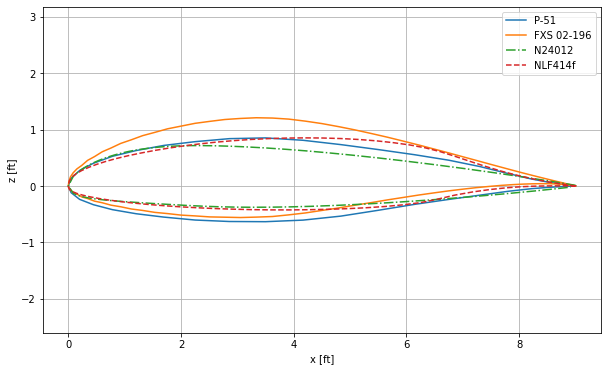

In [3]:
import os
import numpy

p51_root_path = os.path.join('data', f'p51droot-il.csv')
with open(p51_root_path, 'r') as infile:
    x_p51, y_p51 = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',', skiprows=9, max_rows=41)
x_p51 *= 0.00328084 # convert mm to feet
y_p51 *= 0.00328084

fxs02196_path = os.path.join('data', f'fxs02196.dat')
with open(fxs02196_path, 'r') as infile:
    x_glider, y_glider = numpy.loadtxt(infile, unpack=True, skiprows=1)
x_glider *= 9 
y_glider *= 9

naca_path = os.path.join('data', f'naca24012.dat')
with open(naca_path, 'r') as infile:
    x_naca, y_naca = numpy.loadtxt(infile, dtype=float, unpack=True, skiprows=1)
x_naca *= 9
y_naca *= 9

nlf_path = os.path.join('data', f'NLF414f.dat')
with open(nlf_path, 'r') as infile:
    x_nlf, y_nlf = numpy.loadtxt(infile, dtype=float, unpack=True)
x_nlf *= 9
y_nlf *= 9

plt.figure(figsize=(10,6))
plt.plot(x_p51, y_p51, label='P-51')
plt.plot(x_glider, y_glider, label='FXS 02-196')
plt.plot(x_naca, y_naca, label='N24012', linestyle='-.')
plt.plot(x_nlf, y_nlf, label='NLF414f', linestyle='--')
plt.legend()
plt.grid()
plt.axis('equal')
plt.xlabel('x [ft]')
plt.ylabel('z [ft]')
plt.show()


In [4]:
# 1.2b Creating xfoil data with viscous flow
import pyxfoil as p

alphas = np.linspace(start=-30, stop=10, num=81) # coarser region before stall region, step = .5 deg

foil = '23014'
naca = True
p.GetPolar(foil, naca, alphas, Re)

foil = 'data/NLF414f.dat'
naca = False
p.GetPolar(foil, naca, alphas, Re, pane=True)

x_p51 *= 1/9
y_p51 *= 1/9
df = pd.DataFrame({'x': x_p51, 'z': y_p51})
df.to_csv('data/p51d_root.dat', sep=' ', index=False) # fixing the data file
foil = 'data/p51d_root.dat'
p.GetPolar(foil, naca, alphas, Re, pane=True)

foil = 'data/fxs02196.dat'
p.GetPolar(foil, naca, alphas, Re, pane=True)



alphas = np.linspace(start=10, stop=30, num=161) # repeating with finer region closer to stall, step = 0.125 deg

foil = '23014'
naca = True
p.GetPolar(foil, naca, alphas, Re)

foil = 'data/NLF414f.dat'
naca = False
p.GetPolar(foil, naca, alphas, Re, pane=True)

foil = 'data/p51d_root.dat'
p.GetPolar(foil, naca, alphas, Re, pane=True)

foil = 'data/fxs02196.dat'
p.GetPolar(foil, naca, alphas, Re, pane=True)



In [5]:
# Assembling all of the data from the pyxfoil polar files.
# Since I ran pyxfoil with a coarse region and a fine region of alphas, the sets need to be combined here.
f = 'data/fxs02196/fxs02196_polar_Re1.99e+07a-30.0-10.0.dat'
fxs_data1 = np.loadtxt(f, unpack=True, skiprows=12)
f = 'data/fxs02196/fxs02196_polar_Re1.99e+07a10.0-30.0.dat'
fxs_data2 = np.loadtxt(f, unpack=True, skiprows=13)
fxs_data = np.concatenate((fxs_data1, fxs_data2), axis=1)


f = 'data/naca23014/naca23014_polar_Re1.99e+07a-30.0-10.0.dat'
naca_data1 = np.loadtxt(f, unpack=True, skiprows=12)
f = 'data/naca23014/naca23014_polar_Re1.99e+07a10.0-30.0.dat'
naca_data2 = np.loadtxt(f, unpack=True, skiprows=13)
naca_data = np.concatenate((naca_data1, naca_data2), axis=1)


f = 'data/NLF414f/NLF414f_polar_Re1.99e+07a-30.0-10.0.dat'
nlf_data1 = np.loadtxt(f, unpack=True, skiprows=12)
f = 'data/NLF414f/NLF414f_polar_Re1.99e+07a10.0-30.0.dat'
nlf_data2 = np.loadtxt(f, unpack=True, skiprows=13)
nlf_data = np.concatenate((nlf_data1, nlf_data2), axis=1)


f = 'data/p51d_root/p51d_root_polar_Re1.99e+07a-30.0-10.0.dat'
p51_data1 = np.loadtxt(f, unpack=True, skiprows=12)
f = 'data/p51d_root/p51d_root_polar_Re1.99e+07a10.0-30.0.dat'
p51_data2 = np.loadtxt(f, unpack=True, skiprows=13)
p51_data = np.concatenate((p51_data1, p51_data2), axis=1)

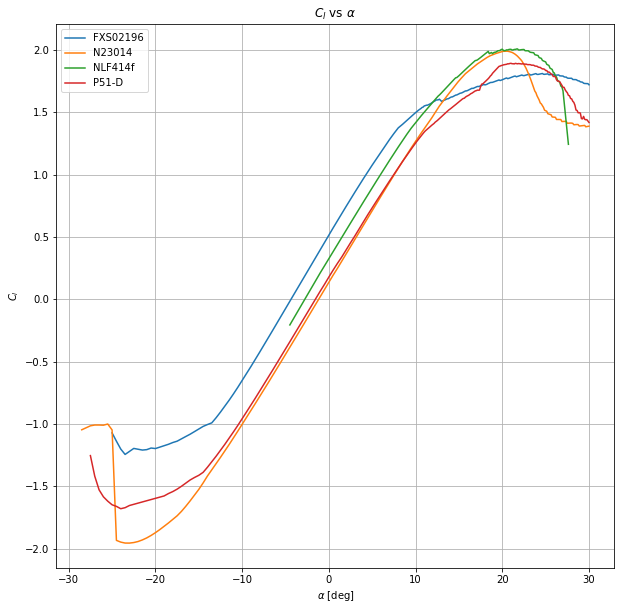

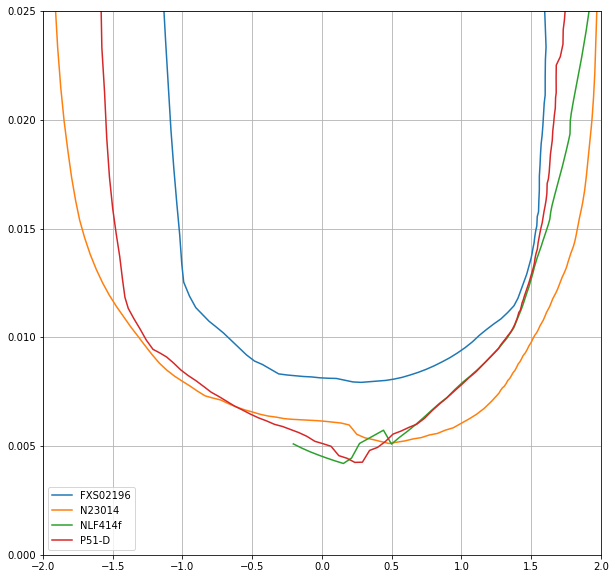

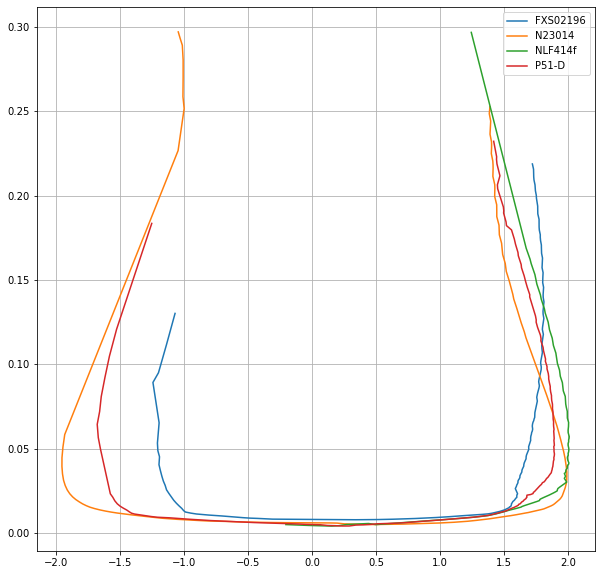

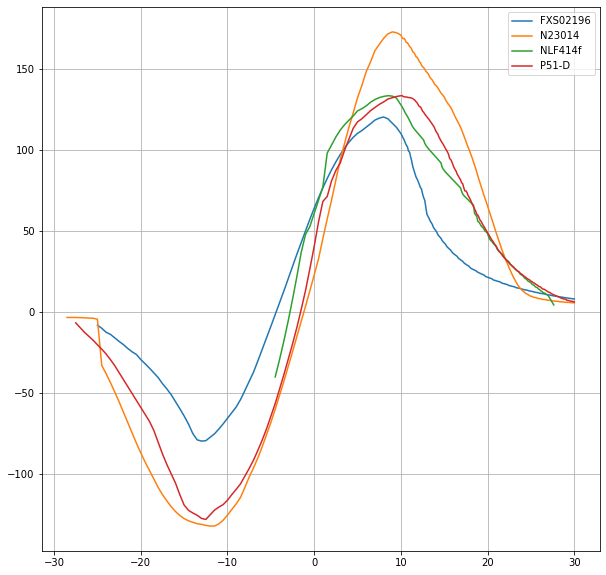

In [6]:
#1.2c Plotting data: viscous lift curves, viscous drag polars, l/d vs a

# Cl v alpha
plt.figure(figsize=(10,10))
plt.plot(fxs_data[0], fxs_data[1], label='FXS02196')
plt.plot(naca_data[0], naca_data[1], label='N23014')
plt.plot(nlf_data[0], nlf_data[1], label='NLF414f')
plt.plot(p51_data[0], p51_data[1], label='P51-D')
plt.legend()
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$C_l$')
plt.title(r'$C_l$ vs $\alpha$')
plt.grid()
plt.show()

# cl vs cd limited for drag buckets
plt.figure(figsize=(10,10))
plt.plot(fxs_data[1], fxs_data[2], label='FXS02196')
plt.plot(naca_data[1], naca_data[2], label='N23014')
plt.plot(nlf_data[1], nlf_data[2], label='NLF414f')
plt.plot(p51_data[1], p51_data[2], label='P51-D')
plt.legend()
plt.ylim([0, 0.025])
plt.xlim([-2, 2])
plt.grid()
plt.show()

# cl vs cd unlimited for high alpha
plt.figure(figsize=(10,10))
plt.plot(fxs_data[1], fxs_data[2], label='FXS02196')
plt.plot(naca_data[1], naca_data[2], label='N23014')
plt.plot(nlf_data[1], nlf_data[2], label='NLF414f')
plt.plot(p51_data[1], p51_data[2], label='P51-D')
plt.legend()
plt.grid()
plt.show()

# l/d vs alpha using cl/cd as l/d equivalent
plt.figure(figsize=(10,10))
plt.plot(fxs_data[0], fxs_data[1]/fxs_data[2], label='FXS02196')
plt.plot(naca_data[0], naca_data[1]/naca_data[2], label='N23014')
plt.plot(nlf_data[0], nlf_data[1]/nlf_data[2], label='NLF414f')
plt.plot(p51_data[0], p51_data[1]/p51_data[2], label='P51-D')
plt.legend()
plt.grid()
plt.show()